In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math
import random

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.rcParams["figure.figsize"] = (8,8)

UsageError: Line magic function `%` not found.


# Multiple Regression

Doing a simple linear regression is cool, but for this to be really useful we want to be able to use a bunch of factors to make a prediction. The process is largely the same, we just have more variables on the input (X) side. It is also difficult/impossible to visualize, since we'd need to see in 3+ dimensions.  

## Exploratory Data Analysis

First, we'll get some data, and look at what the target and the features are going to be. This is a really simplifed example of some EDA that we normally do in advance of machine learning. The first step to any predictive model building is to look at our data and see if anything should be done prior to modelling. This is pretty vague, but we are basically looking to see if there's anything in the data that might be suboptimal for the predictions we want to create. Some common things to look for are:
<ul>
<li> Errors - anything that is just "wrong", words in numeric columns, mislabeled values, etc...
<li> Outliers - values too large or too small. 
<li> Weird Distributions - this is very open-ended, but think of something like a numerical feature where the variance is exceeding low. If every row of the data has the same value, it probably won't help in making predictions, which is inheirently seeking to discriminate. For example, some schools in Japan used to force students to dye their hair black if it wasn't already; if hair color was a feature in your dataset, it wouldn't really add any value if 99.9% of rows of data is "black". 
<li> Missing Values - how should we deal with it if some values are blank?
</ul>

This isn't a conclusive list, and as we explore we may find other things to change or remove. The amount of work we may need to do can also vary widely - if the data is comming from something like a PoS system it will probably be pretty clean and not require many changes; if the data is coming from scraping social media sites from that people fill out, the data may well require massive amounts of cleaning. 

In [2]:
#Get data
#I'll drop density to make it more realistic.
df = pd.read_csv("data/bodyfat.csv")
df = df.drop(columns={"Density"})
df.head()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


Cool. We'll predict the BodyFat (which is hard to accurately measure) by using the other stuff, which is easier to measure. 

Before we start, we want to do some exploration of the data.

In [3]:
#Start Exploring the Data
df.describe()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


At a glance, it looks like there aren't a lot of issues. One thing I notice is that there's a BodyFat reading of 0 for the min. That isn't possible, so we'll need to get rid of that. 

In [4]:
#Get variable info. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BodyFat  252 non-null    float64
 1   Age      252 non-null    int64  
 2   Weight   252 non-null    float64
 3   Height   252 non-null    float64
 4   Neck     252 non-null    float64
 5   Chest    252 non-null    float64
 6   Abdomen  252 non-null    float64
 7   Hip      252 non-null    float64
 8   Thigh    252 non-null    float64
 9   Knee     252 non-null    float64
 10  Ankle    252 non-null    float64
 11  Biceps   252 non-null    float64
 12  Forearm  252 non-null    float64
 13  Wrist    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


All of our variables are correctly identified as numbers. Often if there's some erroneous data in a column it might get miscategorized as an object. Since we'll be dealing with non-numeric data in ML, starting next workbook, we probably want to double check.  

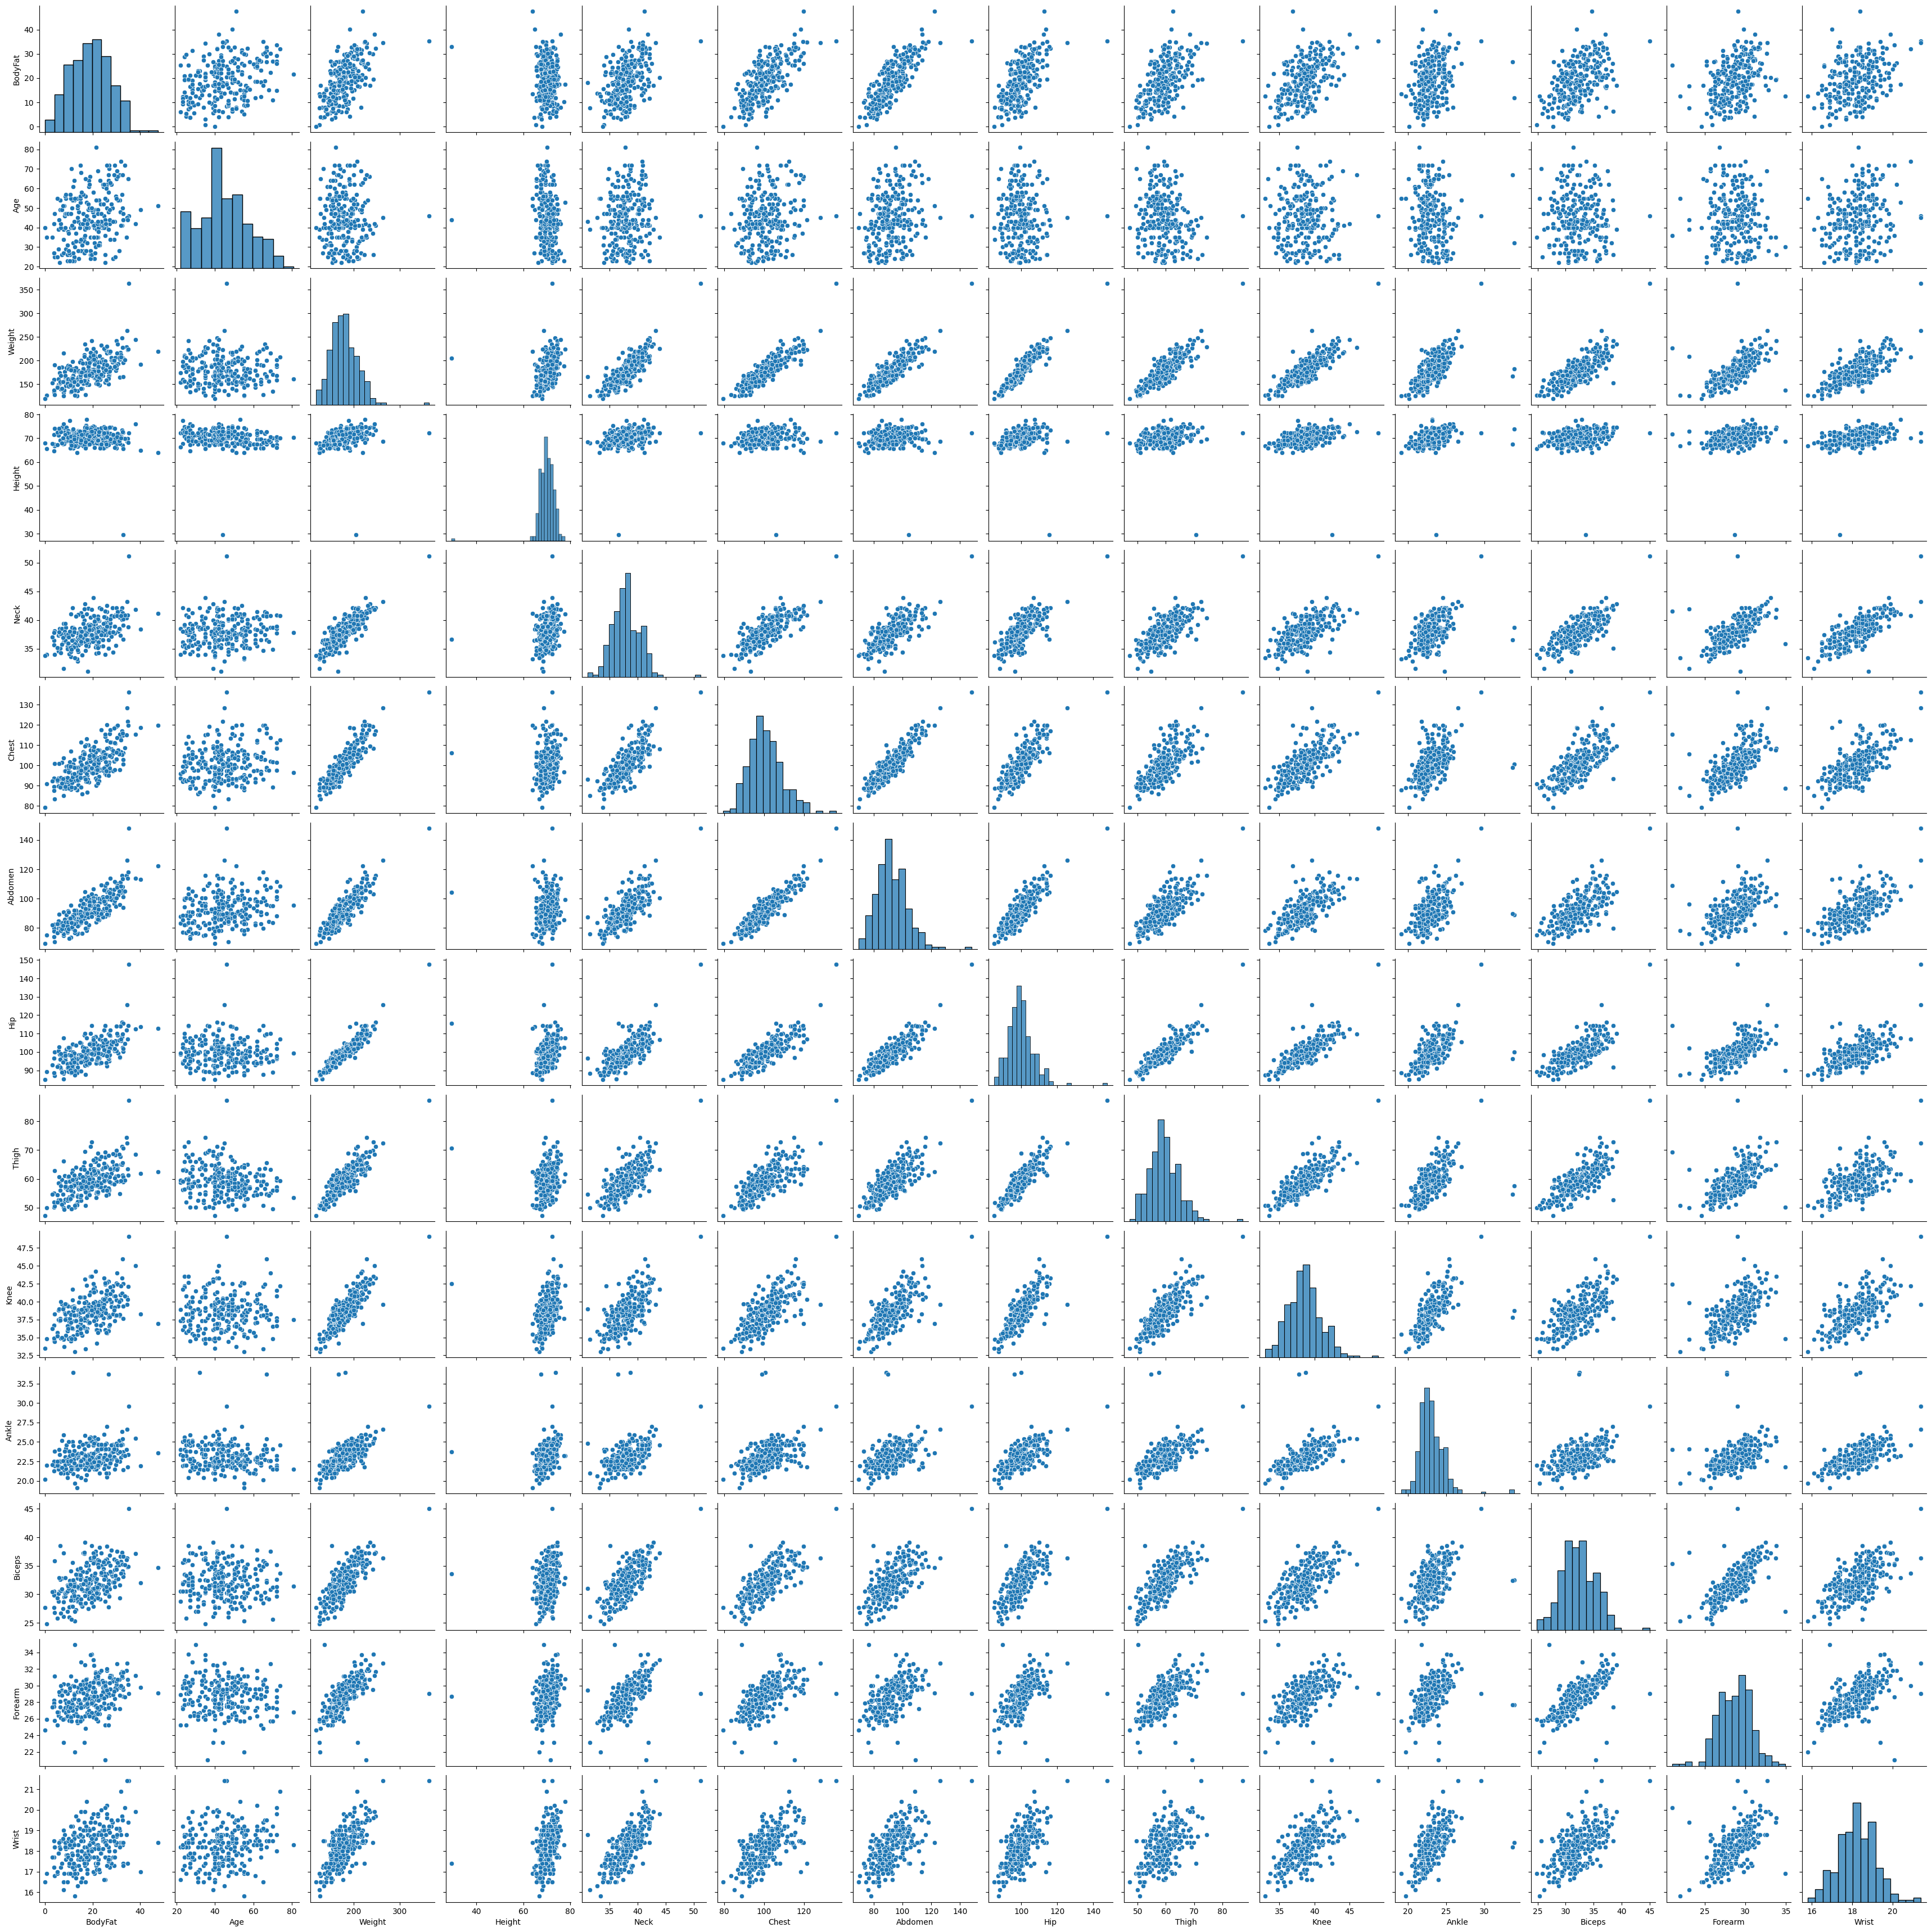

In [5]:
#Visual correlation and distributions
sns.pairplot(df)

It appears there are some outliers that probably aren't helping - e.g. Height. 

##### Check for Missing Values

In [6]:
#Are there nulls?
df.isnull().sum().sort_values()

BodyFat    0
Age        0
Weight     0
Height     0
Neck       0
Chest      0
Abdomen    0
Hip        0
Thigh      0
Knee       0
Ankle      0
Biceps     0
Forearm    0
Wrist      0
dtype: int64

##### Filter Outliers

In [7]:
# Remove some outliers
# These were judgement cals. 
# E.g. it is theoretically possible for someone to have fat < 5%, but that's really only people like
# bodybuilders at a competition time. Those types of extreme outliers probably wont' help our model. 
df = df[df["BodyFat"] > 5]
df = df[df["Height"] > 40]
df = df[df["Weight"] < 300]
df = df[df["Ankle"] < 30]
df.describe()

,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,19.567917,45.183333,179.283542,70.369792,38.017500,101.036667,92.845417,99.954583,59.490833,38.639167,23.019167,32.315417,28.715833,18.245833
std,7.882082,12.595399,26.490546,2.573394,2.283016,7.988003,9.943732,6.312051,4.786426,2.273655,1.343436,2.873813,2.025176,0.913488
min,5.200000,22.000000,125.000000,64.000000,31.100000,85.100000,72.800000,85.300000,49.300000,33.000000,19.100000,25.300000,21.000000,15.800000
25%,13.575000,37.000000,159.937500,68.500000,36.400000,95.325000,85.925000,95.600000,56.375000,37.275000,22.000000,30.300000,27.300000,17.600000
50%,19.500000,44.000000,176.875000,70.250000,38.000000,99.750000,91.600000,99.300000,59.100000,38.600000,22.800000,32.100000,28.800000,18.300000
75%,25.300000,54.000000,197.250000,72.250000,39.525000,105.600000,99.725000,103.625000,62.350000,40.000000,24.000000,34.400000,30.025000,18.800000
max,47.500000,81.000000,262.750000,77.750000,43.900000,128.300000,126.200000,125.600000,74.400000,46.000000,27.000000,39.100000,34.900000,21.400000


##### Examine Distributions Post-Outliers

In [8]:
#Check with cleaned data. 
sns.pairplot(df)

Looks pretty good. We may want to examine some of the outliers a bit more closely, but overall the data looks pretty usable. Distributions are all pretty normal. Large outliers are gone. Nothing really jumps out as being a problem.

There does appear to be a large amount of correlation between variables. We'll worry about that later on, for now, looks good. Time to start regressing...


## Setup the data

The basic idea here is the same as one variable regression, only instead of one X, we have a bunch. We can't do this with simple functions (thinkstats), at least not easily, so we'll use a package. 

### SciKitLearn Data Setup

In [9]:
#Y data is simple, do that first
y = np.array(df["BodyFat"]).reshape(-1,1)
y.shape

(240, 1)

Y is identical to the single variable stuff. For X, we have a width to our array. We can take a look again to see what we expect. 

In [10]:
#Get a new df with only the features we'll use
df_ = df.drop(columns={"BodyFat"})
df_.head()

,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [11]:
#Make that df into an array. 
x = np.array(df_)
x.shape

(240, 13)

In [12]:
#shapes
print("X shape", x.shape)
print("Y shape", y.shape)

X shape (240, 13)
Y shape (240, 1)


### SKL Regress...

Shape for this one looks good! We have 240 rows, which matches the Y. We have 13 columns, which is what we get if we were to count up the columns by hand. Success!!

Time for regression stuff. 

In [13]:
#Setup
from sklearn.linear_model import LinearRegression
from sklearn import feature_selection
from sklearn.model_selection import train_test_split

#### Split Data

In [14]:
#Split data
xTrain, xTest, yTrain, yTest = train_test_split(x,y,test_size=.3)

##### Train Model

In [15]:
#Generate model 
model = LinearRegression().fit(xTrain,yTrain)

##### Check Results

In [16]:
#Get some info on our new regression model
r_sq = model.score(xTest, yTest)
print('R-squared:', r_sq)

R-squared: 0.7664648735477235


#### View "Slopes" and Intercept

In single regression our model was made up of the slope, and intercept values - we can plug any X in and calculate our prediction. In multiple regression, the results are the same, there's just more of them. We still have one intercept, but now each X has it's own m. The entire equation ends up just having a bunch of "X" terms:

$ y = m1 * x1 + m2 * x2 + m3 * x3 ... + b $

We can extract the values just as we did before, we could also make a manual model to generate predictions - our equation would just be longer than the y = mx + b ones that we created earlier. 

#### Visualizing Multiple Regression

The idea of how multiple regression works is the same, it is just harder to visualize. If we try to look at an example with 2 features (so 3 total values, with the target) and picture it a little. In a single regression we make a prediction by doing a "lookup" in one dimension - the X value is our input, we slide along the X axis until we find that value, then look up to the regression line to see what the target is at that point. In a 2 feature regression, the same idea applies, only we do the lookup with two X values on a plane and the prediction is where they intersect on the 3rd axis:

![3D Regression](images/3d_regression.png "3D Regression")

Now our model, or our line of best fit, is a plane - a two dimensional line. Each feature we add ups that number of dimensions by 1, and it is always 1 less than the total number of dimensions. In a single regression teh value on one axis predicts the other axis, in a multiple regression the value on [# of features] axis, where they interesect, predicts the value on the other axis. Same, same. 

Going up in features, the same idea always applies, we just don't have a timecube to draw it. If we had 13 features like we do above, we'd have a scatter plot in 14 dimensional space, and we'd look to the intercept of the 13 features, which would give us our prediction on the 14th axis - the one belonging to the target. 

In [17]:
#Our coefficent/slope is now an array of values - one per X. 
#Visualizing the regression would be a 14D space, where these are the slopes in each dimension. 
print('Intercept:', model.intercept_[0])
print('Coefs:', model.coef_[0])

Intercept: 24.620188613376648
Coefs: [ 0.03955839  0.01911451 -0.42046433 -0.63646418 -0.10263176  0.8399188
 -0.23708109  0.13760042 -0.03090028  0.10370888  0.23287958  0.13888788
 -1.1695472 ]


##### Error Metrics

Get the residuals to calculate RMSE. 

The residual stuff is the same no matter how many Xs we have on the input side, since all we are checking is the Y values. 

In [18]:
#Get RMSE
tmp = model.predict(xTest)
mean_squared_error(tmp, yTest, squared=False)

3.756956486138098

##### Residuals

We don't generally need to view the residuals if we aren't doing things by hand, the library functions allow us to just look at the summary statistics like RMSE. We can view them for fun, just to confirm they exist. 

In [19]:
#Get Residuals and picture them in a DF for easy reading. 
tmp1 = pd.DataFrame(yTest, columns={"Y values"})
tmp2 = pd.DataFrame(tmp, columns={"Predictions"})
tmp3 = pd.DataFrame((yTest-tmp), columns={"Residual"})
resFrame = pd.concat([tmp1,tmp2,tmp3], axis=1)
resFrame.head()

,Y values,Predictions,Residual
0,8.8,12.512093,-3.712093
1,29.0,28.481680,0.518320
2,19.7,19.936469,-0.236469
3,20.5,21.646505,-1.146505
4,11.7,11.123365,0.576635


Easy!!

<h3>Statsmodels style</h3>

In [20]:
#Statsmodels.
import statsmodels.api as sm

In [21]:
#Fit the model. 
X2 = sm.add_constant(xTrain)
est = sm.OLS(yTrain, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     29.08
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           5.61e-35
Time:                        21:40:59   Log-Likelihood:                -481.13
No. Observations:                 168   AIC:                             990.3
Df Residuals:                     154   BIC:                             1034.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.6202     30.340      0.811      0.4

The x's are the input features in order. They are showing without their names because for the input we just used the arrays from the sklearn example above. Things like this are reasonably common when we're doing ML, as most other algorithms don't really give detailed data for each feature like linear regression does, so having them listed by names isn't super useful. To get the labels we could:
<ul>
<li>Feed the statsmodel a formula, like we have in the book. 
<li>Use a dataframe as an input. (Coming up)
<li>Create a list of column names and match the up after the fact - reconstructing output that you want from the values you want.
</ul>

In [22]:
#RMSE
ypred = est2.predict(sm.add_constant(xTest))
mean_squared_error(yTest,ypred, squared=False)

3.7569564861381046

## Exercise

In [23]:
# Load data and remove bodyfat
dfE = pd.read_csv("data/bodyfat.csv")
dfE.drop(columns={"BodyFat"}, inplace=True)
dfE.head()

,Density,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [24]:
#Setup Data
yE = np.array(dfE["Density"]).reshape(-1,1)
xE = np.array(dfE.drop(columns={"Density"}))
xE.shape, yE.shape

((252, 13), (252, 1))

In [25]:
#Split and Train
xTrainE, xTestE, yTrainE, yTestE = train_test_split(xE,yE,test_size=.3)
#Generate model 
modelE = LinearRegression().fit(xTrainE,yTrainE)

In [26]:
#Score 
#Get RMSE and R2
tmpE = modelE.predict(xTestE)
rmseE = mean_squared_error(tmpE, yTestE, squared=False)
r_sqE = modelE.score(xTestE, yTestE)

print("RMSE:", rmseE)
print('R-squared:', r_sqE)

RMSE: 0.010034423613450449
R-squared: 0.6903318666026235


## Multicollinearity - Useful, but Less Critical

For fun, we'll look at the multicollinearity, because it is crazy high in this example. Look back at the pairplot, most varaibles appear highly correlated with each other - as one increases, the other does as well. This makes sense logically, as these are all measures of the body size; as your wrist size increases, so does your forearm, and your bicep, etc... They are closely correlated. One effect of this is that the impact of each variable is hard to pinpoint, as all the varaibles are largely measuring the same thing. 

Addressing this won't make our accuracy measures get way better, but it will allow us to better attribute the impact to the individual features, which is one advantage to a linear regression - that table of results give us some data that we can use to edit our model. 

We can calculate the VIF - variance inflation factor. This is a measure of multicollinearity. The calculation is VIF = 1/(1-R2), so as R2 gets closer to 1, the VIF gets larger. If we think of it in R2 terms - a big R2 indicates that a large percentage in the varaince of the results is captured in the model. Here, the R2 is how much of the variance of the other features is explained by each feature. So if they are higly correlated that value will be high and R2 will be high, leading to a big VIF value. If the R2 is low, then the varaible doesn't capture varaiance in the other features, so it is different from them, or it captures different data. In this case the R2 is small, so the VIF is small. 

The rule of thumb is that a VIF of ~10 should be looked at. 

### Variance Varies

One way that makes a lot of sense to me to think of in this case, R2, and a few other places is to think of a measure of how much the data varies, and what is "causing" that varaince - as an intuitive sense, not a literal causitive relationship. 

Here, we can start with the assumption that the target varries - it literally just takes on different values. 
<ul>
<li> If we look back to R2, that's a measure of how much of that variance is captured in the model - or put in this context, the target varries a bunch, and R2% of that variation is "caused" (or captured by, more accurately) the things that we have in our model, and (1-R2%) is due to other stuff - whatever our model is missing. A complete model captures most of the things that cause the data to differ - if we step back and think about it logically and not statistically, this makes a lot of sense to me personally. 
<li> If we look at ANOVA (the f-score in particular) what we are looking for is a measure of what varies more. Do we see more change (variance in the data) when comparing two groups, which is an indication that the groups are different, or do we see more change when comparing the values inside of a group (indicating the groups are more similar). 
<li> Here, we are ultimately looking to attribute the varaiance in the target to the set of features that really matters. When measuring the VIF, we are basically asking the question, "does the data still vary just as much without this varaible?" If we have a high VIF that tells us that this varaible doesn't really "add any information" - the data varies almost/just as much with it gone, so it wasn't a determinative factor in making the data change. If the VIF is low, that tells us that the amount the data changes (varies) is dependent on this varaible - it contains information that makes the data change.
</ul>

Again, this is a mental model that makes sense to me, it is not a specific calculation or rule. On the whole, in predicive analytics, we are attempting to determine "what causes this data to vary", so we can use those things to make a prediction. The more of that varying we capture, the better we generally do. We can also look backwards, like we are here, and attempt to attribute that varaiance we see to different "causes", so we can do stuff like remove the ones that aren't making that much of an impact. 

In [27]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Function will check the VIF of each variable in a DF and return the results in another DF
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

In [28]:
#Check VIFs
calc_vif(df_)

,variables,VIF
0,Age,33.200851
1,Weight,282.792663
2,Height,902.061325
3,Neck,1022.394337
4,Chest,1162.837783
5,Abdomen,940.348375
6,Hip,2296.398214
7,Thigh,1041.341120
8,Knee,1264.965247
9,Ankle,878.089302


##### View the Correlations

In [29]:
sns.pairplot(df[["Hip", "Knee", "Wrist", "Chest","Neck","Thigh","Ankle"]])

#### Filter Out the Values

All the scores are huge. We expected this since they all almost overlap on that pairplot earlier. What this tells us is that the information in each varaible has lots of overlap - in this case they all measure bodyfat, fairly directly. If we think about the real world impact of this it makese sense - the cheap and easy way to measure bodfat is by taking measurements and caliper pinches all over one's body. We'd expect the measurements to all be pretty correlated - it'd be a bit odd to have a huge wrist and a tiny ankle, or a big thigh and tiny knee. A few people might stand out, particularly very muscular people, but most people will be pretty consistent between every measurement based on fat level. 

How accurate will this model be if we drop a bunch of the high VIF stuff?

In [30]:
#Remove some high VIF columns
df_2 = df_.drop(columns={"Hip", "Knee", "Wrist", "Chest","Neck","Thigh","Ankle"})

In [31]:
#Run statsmodesl to get results
X2 = sm.add_constant(df_2)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     95.98
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           3.80e-60
Time:                        21:41:04   Log-Likelihood:                -686.19
No. Observations:                 240   AIC:                             1386.
Df Residuals:                     233   BIC:                             1411.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -31.5741     14.317     -2.205      0.0

In [32]:
#Recheck
calc_vif(df_2)

,variables,VIF
0,Age,19.055106
1,Weight,262.485765
2,Height,232.098210
3,Abdomen,412.340380
4,Biceps,349.452758
5,Forearm,394.405584


In [33]:
#RMSE for smaller model 
x2 = np.array(df_2)
x2.shape
model2 = LinearRegression().fit(x2,y)
ypred2 = model2.predict(x2)
mean_squared_error(y,ypred2,squared=False)

4.221538974738081

<h3>Smaller Model Results</h3>

Removing variables doesn't up the R2 - we'll explore that more later on in ML.

The RMSE doesn't get much worse (and the change is within the expectation of randomness here) - that makes sense because what we found with this multicollinearity was that each varaible contained the same information. So when we remove one duplicate piece of that information, not much changes. This process is called feature selection, it is one of the big things in ML, and we'll look at it in different ways as we do next semester. 

When we are just using CSVs full of data, there isn't a very large impact in removing a few variables like this. If we were dealing with data that we had to collect - e.g. if we were paying nurses to do all of these measurements on people - then we'd want to minimize the number of features needed, so our nurses could be faster and therefore cheaper. Similarly, if we had massive amounts of data and training our model or storing the data was costly, being able to be accurate with less data is good. We don't often run into constraints in learning, because the data is small, but they can exist. 

In [34]:
#We can cut it down to the bare-bones - I'll take the vars with small p values
df_3 = df[["Abdomen","Weight"]]
X2 = sm.add_constant(df_3)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                     284.3
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           1.09e-63
Time:                        21:41:04   Log-Likelihood:                -688.74
No. Observations:                 240   AIC:                             1383.
Df Residuals:                     237   BIC:                             1394.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.7875      2.714    -16.504      0.0

In [35]:
#RMSE for tiny model 
x2 = np.array(df_3)
x2.shape
model2 = LinearRegression().fit(x2,y)
ypred2 = model2.predict(x2)
mean_squared_error(y,ypred2,squared=False)

4.266493850368595

What's the moral of the story? We can predict almost as well with just two varaibles as we did with all of them!

Challenge - run this with a split of the data. One part to train, another to test. Not the accuracy differences...

In [36]:
#Run above with test/train split